In [27]:
import numpy as np
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from keras.models import Sequential
from keras.layers import Dense

from perceptron import Perceptron
from knn import KNN

In [3]:
data = arff.loadarff(r'C:\Users\USER\OneDrive\Desktop\Statistical Data Science\Year 3 Semester 1\ML\phishing+websites\Training Dataset.arff')
df = pd.DataFrame(data[0])
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.decode('utf-8').astype(float)
df.fillna(df.mean(), inplace=True)

df.shape

(11055, 31)

In [3]:
df.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   having_IP_Address            11055 non-null  float64
 1   URL_Length                   11055 non-null  float64
 2   Shortining_Service           11055 non-null  float64
 3   having_At_Symbol             11055 non-null  float64
 4   double_slash_redirecting     11055 non-null  float64
 5   Prefix_Suffix                11055 non-null  float64
 6   having_Sub_Domain            11055 non-null  float64
 7   SSLfinal_State               11055 non-null  float64
 8   Domain_registeration_length  11055 non-null  float64
 9   Favicon                      11055 non-null  float64
 10  port                         11055 non-null  float64
 11  HTTPS_token                  11055 non-null  float64
 12  Request_URL                  11055 non-null  float64
 13  URL_of_Anchor   

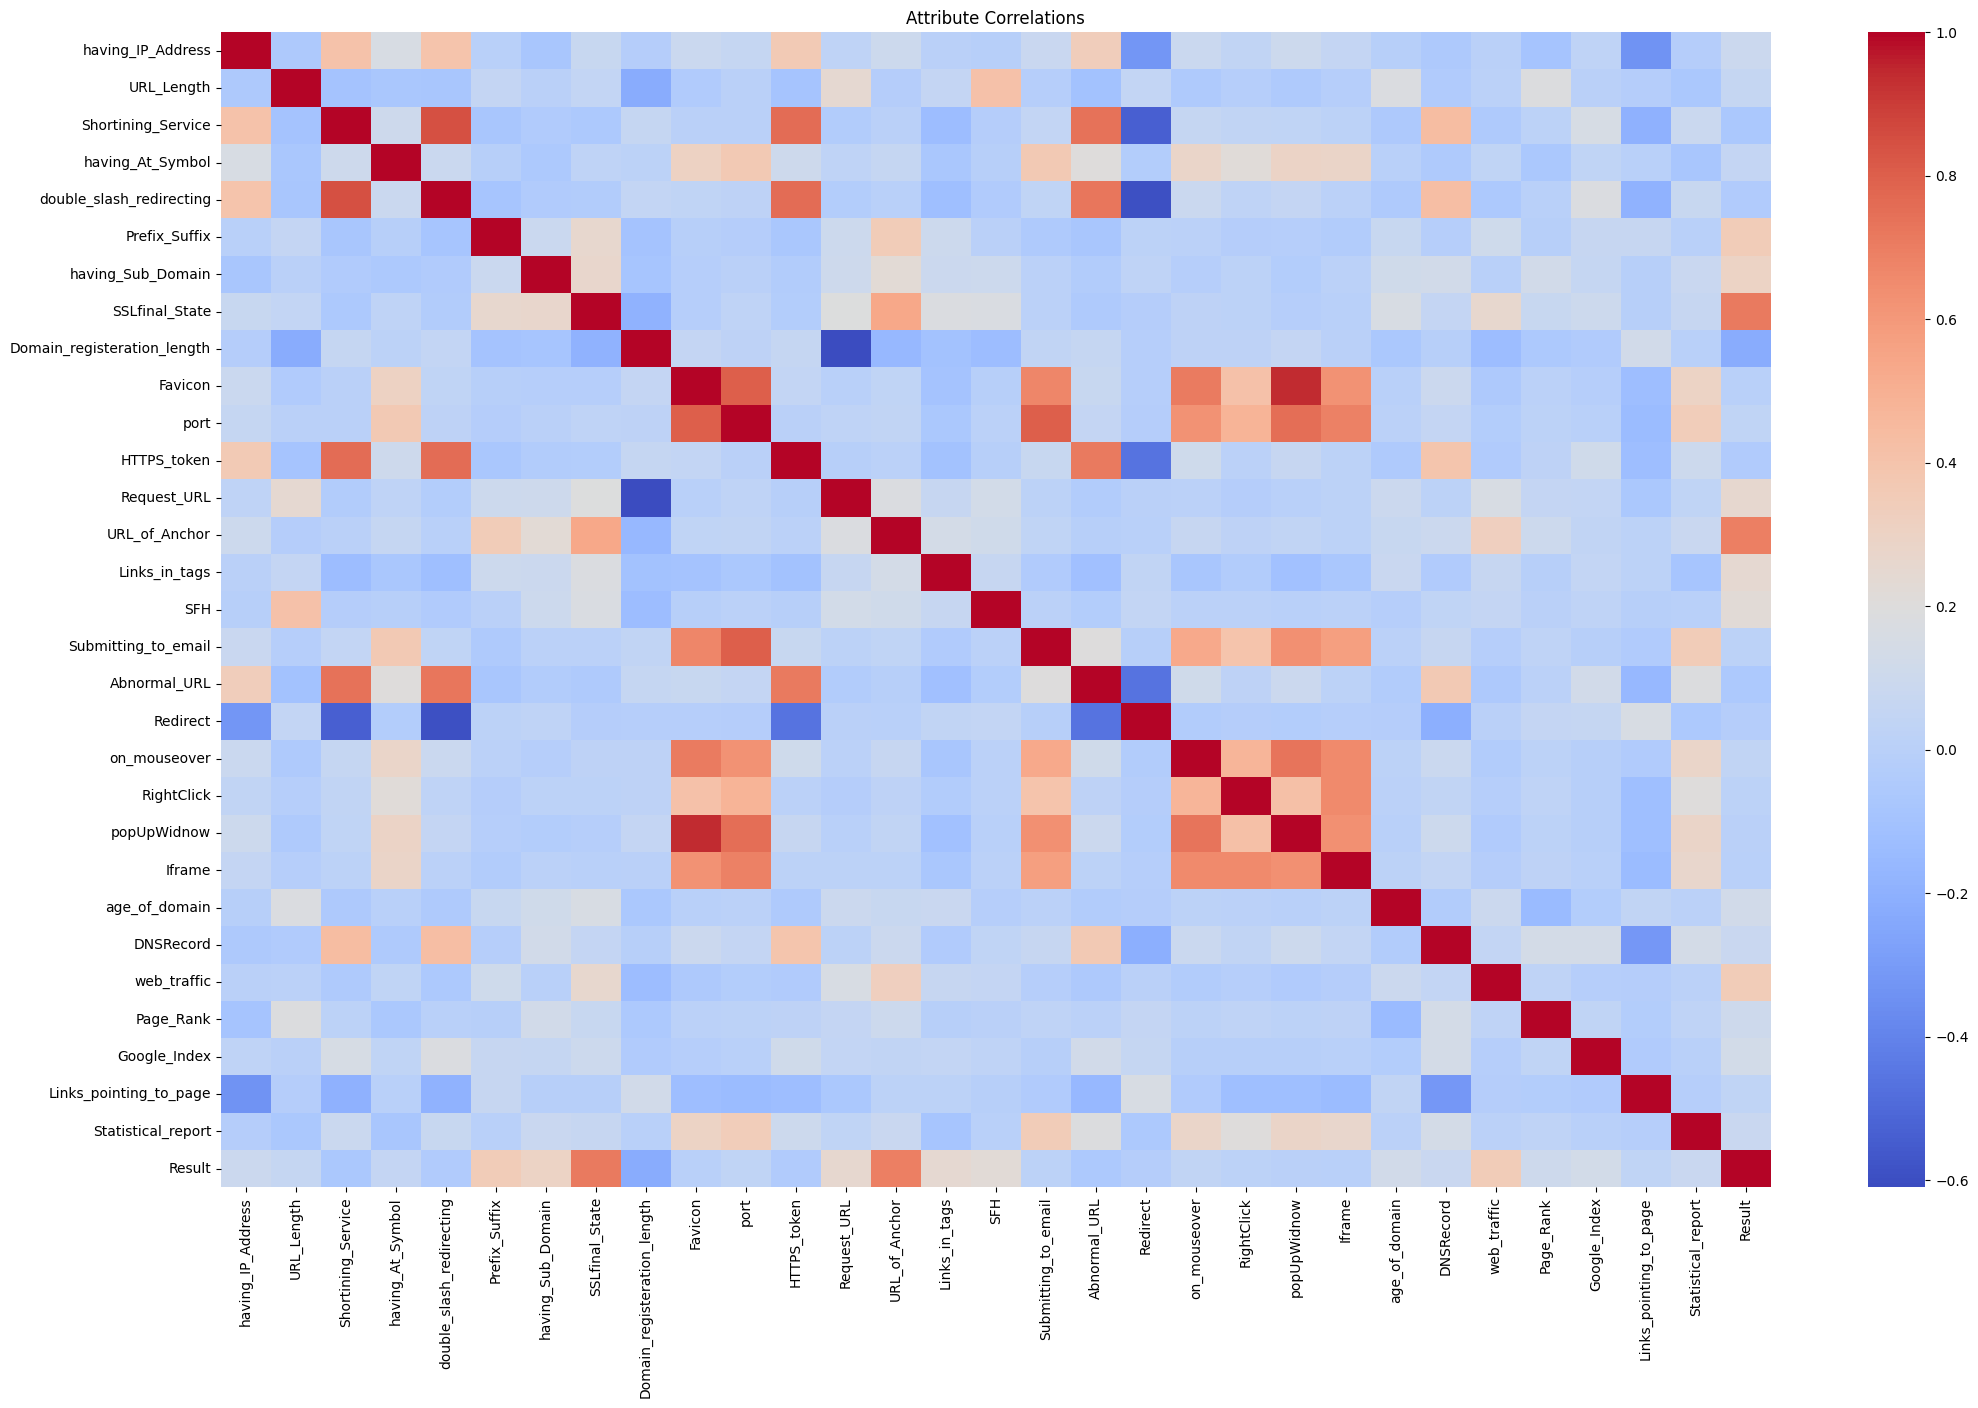

In [5]:
# Heatmap of correlations
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Attribute Correlations')
plt.show()

In [6]:
df_num_corr = df.corr()['Result'][:-1] # -1 because the latest row is 'Result'
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with 'Result':\n{}".format(len(golden_features_list), golden_features_list))

There is 2 strongly correlated values with 'Result':
SSLfinal_State    0.714741
URL_of_Anchor     0.692935
Name: Result, dtype: float64


In [4]:
X = df.drop(columns=['Result']).values  
y = df['Result'].values
y = (y + 1) // 2 

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print("Train set:", X_train.shape)
print("Validate set:", X_val.shape)
print("Test set:", X_test.shape)      

Train set: (7738, 30)
Validate set: (1106, 30)
Test set: (2211, 30)


In [8]:
# Perceptron Implementation
# Train the Perceptron
p = Perceptron(learning_rate=0.01, n_iterations=1)
p.fit(X_train, y_train)

y_predicted = p.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"Validate set accuracy: {accuracy * 100:.2f}%")

y_predicted = p.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Validate set accuracy: 91.59%
Test set accuracy: 92.09%


In [9]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
iterations = [1, 5, 10, 20, 50]
best_lr = 0
best_iter = 0
best_acc = 0

for lr in learning_rates:
    print(f"Learning rate: {lr}")
    for it in iterations:
        p = Perceptron(learning_rate=lr, n_iterations=it)
        p.fit(X_train, y_train)

        y_predicted = p.predict(X_val)
        accuracy = accuracy_score(y_val, y_predicted)
        
        if accuracy > best_acc:
            best_acc = accuracy
            best_lr = lr
            best_iter = it

print(f"Best learning rate: {best_lr}")
print(f"Best iterations: {best_iter}")
print(f"Best validate set accuracy: {best_acc * 100:.2f}%")

p = Perceptron(learning_rate=best_lr, n_iterations=best_iter)
p.fit(X_train, y_train)
y_predicted = p.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Learning rate: 0.0001
Learning rate: 0.001
Learning rate: 0.01
Learning rate: 0.1
Learning rate: 1
Best learning rate: 0.0001
Best iterations: 50
Best validate set accuracy: 91.86%
Test set accuracy: 91.68%


In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    'n_iterations': [1, 5, 10, 20, 50]
}

# Initialize perceptron and GridSearchCV
grid_search = GridSearchCV(Perceptron(), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=<perceptron.Perceptron object at 0x000001F40969D9D0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'n_iterations': [1, 5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [11]:
# Print the best parameters and corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
best_lr = grid_search.best_params_['learning_rate']
best_iter = grid_search.best_params_['n_iterations']

p = Perceptron(learning_rate=best_lr, n_iterations=best_iter)
p.fit(X_train, y_train)
y_predicted = p.predict(X_test)
test_score = accuracy_score(y_test, y_predicted)
print("Test set accuracy with best parameters:", test_score)

Best parameters found: {'learning_rate': 0.1, 'n_iterations': 1}
Best cross-validation score: 0.8759873335897164
Test set accuracy with best parameters: 0.9099954771596562


              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      4898
         1.0       0.87      0.92      0.89      6157

    accuracy                           0.88     11055
   macro avg       0.88      0.87      0.87     11055
weighted avg       0.88      0.88      0.88     11055

[[4017  881]
 [ 490 5667]]


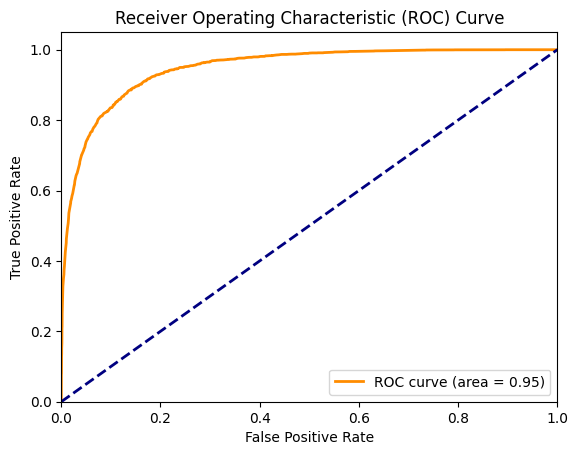

In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(p, X, y, cv=skf)

# Print Metrics
print(classification_report(y, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

# Plot ROC Curve
y_pred_prob = cross_val_predict(p, X, y, cv=skf, method='predict_proba')
y_pred_prob_positive_class = y_pred_prob[:,1]
fpr_p, tpr_p, _ = roc_curve(y, y_pred_prob_positive_class)
roc_auc_p = auc(fpr_p, tpr_p)
plt.figure()
lw = 2
plt.plot(fpr_p, tpr_p, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc_p:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# KNN Implementation
# Train the KNN
knn = KNN(k = 3)
knn.fit(X_train, y_train)

y_predicted = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"Validate set accuracy: {accuracy * 100:.2f}%")

y_predicted = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Validate set accuracy: 93.94%
Test set accuracy: 94.17%


In [14]:
k_value = [3, 5, 7, 9]
best_k = 0
best_acc = 0

for k in k_value:
    print(k)
    knn = KNN(k = k)
    knn.fit(X_train, y_train)

    y_predicted = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_predicted)
        
    if accuracy > best_acc:
        best_acc = accuracy
        best_k = k
    
print(f"Best k: {best_k}")
print(f"Best validate set accuracy: {best_acc * 100:.2f}%")

knn = KNN(k = best_k)
knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

3
5
7
9
Best k: 3
Best validate set accuracy: 93.94%
Test set accuracy: 94.17%


In [15]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
param_grid = {
    'k': [3, 5, 7, 9]
}

# Initialize KNNClassifier and GridSearchCV
grid_search = GridSearchCV(KNN(), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=<knn.KNN object at 0x000001F4340E9850>, n_jobs=-1,
             param_grid={'k': [3, 5, 7, 9]}, scoring='accuracy', verbose=1)

In [16]:
# Print the best parameters and corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
best_k = grid_search.best_params_['k']

knn = KNN(k = best_k)
knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)
test_score = accuracy_score(y_test, y_predicted)
print("Test set accuracy with best parameters:", test_score)

Best parameters found: {'k': 3}
Best cross-validation score: 0.9500667686743636
Test set accuracy with best parameters: 0.9416553595658074


In [22]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(knn, X, y, cv=skf)

# Print Metrics
print(classification_report(y, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      4898
         1.0       0.95      0.96      0.96      6157

    accuracy                           0.95     11055
   macro avg       0.95      0.95      0.95     11055
weighted avg       0.95      0.95      0.95     11055

[[4586  312]
 [ 240 5917]]


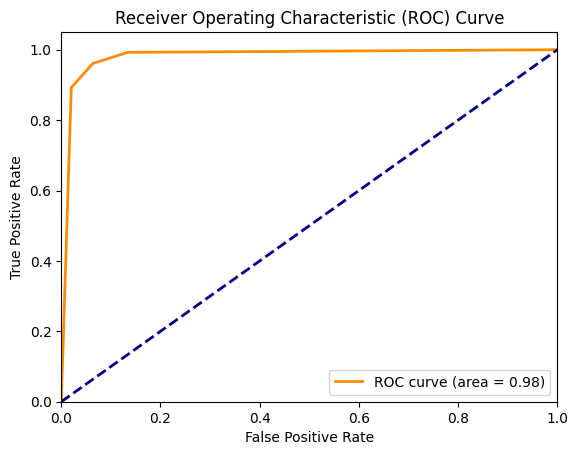

In [21]:
# Plot ROC Curve
y_pred_prob = cross_val_predict(knn, X, y, cv=skf, method='predict_proba')
y_pred_prob_positive_class = y_pred_prob[:, 0]
fpr_knn, tpr_knn, _ = roc_curve(y, y_pred_prob_positive_class)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
lw = 2
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Decision Tree Implementation
# Train the Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)

y_predicted = dt.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"Validate set accuracy: {accuracy * 100:.2f}%")

y_predicted = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Validate set accuracy: 95.48%
Test set accuracy: 94.80%


In [52]:
max_depth_list = [5, 10, 15, 20, 25, 30, 35, 40]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
best_acc = 0

for depth in max_depth_list:
    print(f"Max depth: {depth}")
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            dt = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            dt.fit(X_train, y_train)

            y_predicted = dt.predict(X_val)
            accuracy = accuracy_score(y_val, y_predicted)
            
            if accuracy > best_acc:
                best_acc = accuracy
                best_depth = depth
                best_split = split
                best_leaf = leaf
                
print(f"Best max depth: {best_depth}")
print(f"Best min samples split: {best_split}")
print(f"Best min samples leaf: {best_leaf}")
print(f"Best validate set accuracy: {best_acc * 100:.2f}%")

dt = DecisionTreeClassifier(max_depth=best_depth, min_samples_split=best_split, min_samples_leaf=best_leaf)
dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Max depth: 5
Max depth: 10
Max depth: 15
Max depth: 20
Max depth: 25
Max depth: 30
Max depth: 35
Max depth: 40
Best max depth: 25
Best min samples split: 2
Best min samples leaf: 1
Best validate set accuracy: 96.84%
Test set accuracy: 96.20%


In [53]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
}

# Create the grid search with 10-fold cross validation
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [170]:
# Print the best parameters and corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_criterion = grid_search.best_params_['criterion']
best_splitter = grid_search.best_params_['splitter']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

dt = DecisionTreeClassifier(max_depth=best_max_depth, 
                                min_samples_split=best_min_samples_split, 
                                criterion=best_criterion, 
                                splitter=best_splitter, 
                                min_samples_leaf=best_min_samples_leaf)

dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)
test_score = accuracy_score(y_test, y_predicted)
print("Test set accuracy with best parameters:", test_score)

Best parameters found: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best cross-validation score: 0.9687916179129881
Test set accuracy with best parameters: 0.9715061058344641


              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      4898
         1.0       0.97      0.97      0.97      6157

    accuracy                           0.97     11055
   macro avg       0.97      0.96      0.96     11055
weighted avg       0.97      0.97      0.97     11055

[[4685  213]
 [ 171 5986]]


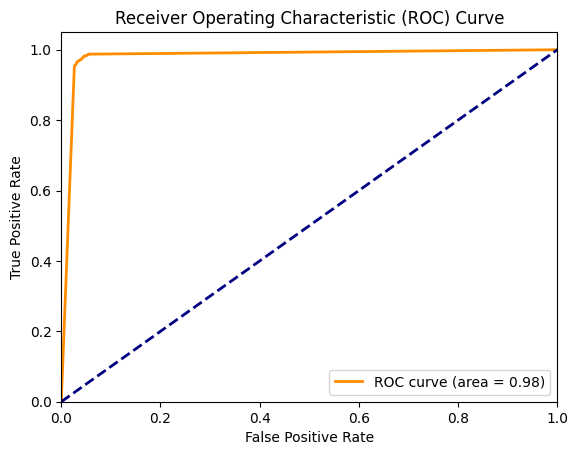

In [171]:
y_pred = cross_val_predict(dt, X, y, cv=skf)

# Print Metrics
print(classification_report(y, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

# Plot ROC Curve
y_pred_prob = cross_val_predict(dt, X, y, cv=skf, method='predict_proba')
y_pred_prob_positive_class = y_pred_prob[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y, y_pred_prob_positive_class)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.figure()
lw = 2
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Naive Bayes Implementation
X_1 = X + 1
y_1 = y + 1
X_train_1 = X_train + 1
y_train_1 = y_train + 1
X_val_1 = X_val + 1
y_val_1 = y_val + 1
X_test_1 = X_test + 1
y_test_1 = y_test + 1

# Train the Naive Bayes
nb = CategoricalNB()
nb.fit(X_train_1, y_train_1)

y_predicted = nb.predict(X_val_1)
accuracy = accuracy_score(y_val_1, y_predicted)
print(f"Validate set accuracy: {accuracy * 100:.2f}%")

y_predicted = nb.predict(X_test_1)
accuracy = accuracy_score(y_test_1, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Validate set accuracy: 92.95%
Test set accuracy: 92.94%


In [180]:
alpha = [0.001, 0.1, 1, 10, 50, 200, 500]
best_acc = 0
best_alpha = 0

for a in alpha: 
    nb = CategoricalNB(alpha=a)
    nb.fit(X_train_1, y_train_1)

    y_predicted = nb.predict(X_val_1)
    accuracy = accuracy_score(y_val_1, y_predicted)
    
    if accuracy > best_acc:
        best_acc = accuracy
        best_alpha = a
        
print(f"Best alpha: {best_alpha}")
print(f"Best validate set accuracy: {best_acc * 100:.2f}%")

nb = CategoricalNB(alpha=best_alpha)
nb.fit(X_train_1, y_train_1)
y_predicted = nb.predict(X_test_1)
accuracy = accuracy_score(y_test_1, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Best alpha: 0.001
Best validate set accuracy: 92.95%
Test set accuracy: 92.94%


In [181]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
param_grid = {
    'alpha': [0.001, 0.1, 1, 10, 50, 200, 500]
}

grid_search = GridSearchCV(CategoricalNB(), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_1, y_1)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 50, 200, 500]},
             scoring='accuracy', verbose=1)

In [182]:
# Print the best parameters and corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
best_alpha = grid_search.best_params_['alpha']

nb = CategoricalNB(alpha=best_alpha)
nb.fit(X_train_1, y_train_1)
y_predicted = nb.predict(X_test_1)
test_score = accuracy_score(y_test_1, y_predicted)
print("Test set accuracy with best parameters:", test_score)

Best parameters found: {'alpha': 0.001}
Best cross-validation score: 0.9295336011717248
Test set accuracy with best parameters: 0.9294436906377205


              precision    recall  f1-score   support

         1.0       0.94      0.90      0.92      4898
         2.0       0.93      0.95      0.94      6157

    accuracy                           0.93     11055
   macro avg       0.93      0.93      0.93     11055
weighted avg       0.93      0.93      0.93     11055

[[4425  473]
 [ 306 5851]]


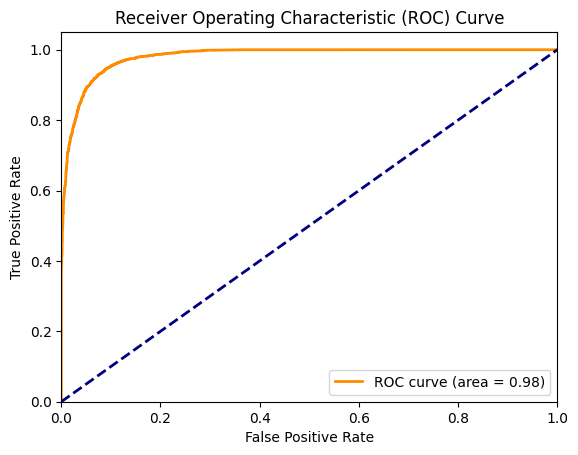

In [179]:
y_pred = cross_val_predict(nb, X_1, y_1, cv=skf)

# Print Metrics
print(classification_report(y_1, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_1, y_pred)
print(conf_matrix)

# Plot ROC Curve
y_pred_prob = cross_val_predict(nb, X_1, y_1, cv=skf, method='predict_proba')
y_pred_prob_positive_class = y_pred_prob[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y, y_pred_prob_positive_class)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
lw = 2
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [183]:
# Build the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)

# Train the model
mlp.fit(X_train, y_train)

y_predicted = mlp.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"Validate set accuracy: {accuracy * 100:.2f}%")

y_predicted = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Validate set accuracy: 97.11%
Test set accuracy: 96.43%


In [186]:
hidden_layer_sizes = [(50,), (100,)]
activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
max_iter = [500, 1000]
best_acc = 0

for layer in hidden_layer_sizes:
    print(f"Hidden layer sizes: {layer}")
    for act in activation:
        for sol in solver:
            for iter in max_iter:
                mlp = MLPClassifier(hidden_layer_sizes=layer, activation=act, solver=sol, max_iter=iter)
                mlp.fit(X_train, y_train)

                y_predicted = mlp.predict(X_val)
                accuracy = accuracy_score(y_val, y_predicted)
                
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_layer = layer
                    best_act = act
                    best_sol = sol
                    best_iter = iter

print(f"Best hidden layer sizes: {best_layer}")
print(f"Best activation: {best_act}")
print(f"Best solver: {best_sol}")
print(f"Best max iterations: {best_iter}")
print(f"Best validate set accuracy: {best_acc * 100:.2f}%")

mlp = MLPClassifier(hidden_layer_sizes=layer, activation=act, solver=sol, max_iter=iter)
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Hidden layer sizes: (50,)


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden layer sizes: (100,)


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hidden layer sizes: (100,)
Best activation: tanh
Best solver: adam
Best max iterations: 1000
Best validate set accuracy: 97.92%
Test set accuracy: 96.38%


In [187]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Define a parameter grid to search for best parameters
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000],
}

# Create GridSearchCV object
grid_search = GridSearchCV(MLPClassifier(), param_grid=param_grid, n_jobs=-1, scoring='accuracy', cv=skf, verbose=2)

# Fit GridSearchCV
grid_search.fit(X, y)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [500, 1000], 'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=2)

In [191]:
# Best parameters found
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']
best_activation = grid_search.best_params_['activation']
best_solver = grid_search.best_params_['solver']
best_learning_rate = grid_search.best_params_['learning_rate']
best_max_iter = grid_search.best_params_['max_iter']

mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver,
                    learning_rate=best_learning_rate, max_iter=best_max_iter)
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
test_score = accuracy_score(y_test, y_predicted)
print("Test set accuracy with best parameters:", test_score)

Best parameters found:  {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}
Best cross-validation score:  0.9730434569153854
Test set accuracy with best parameters: 0.9701492537313433


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      4898
         1.0       0.97      0.98      0.97      6157

    accuracy                           0.97     11055
   macro avg       0.97      0.97      0.97     11055
weighted avg       0.97      0.97      0.97     11055

[[4695  203]
 [ 113 6044]]


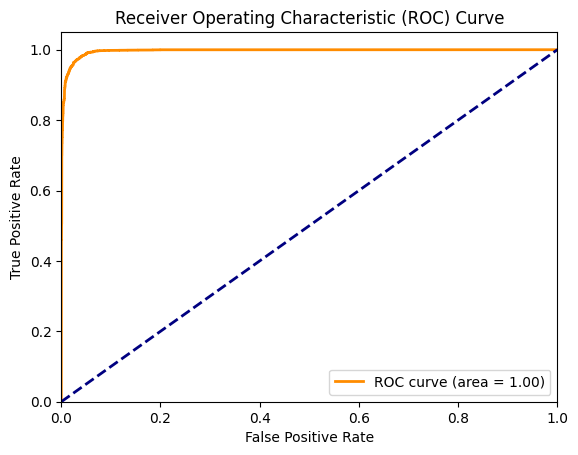

In [189]:
y_pred = cross_val_predict(mlp, X, y, cv=skf)

# Print Metrics
print(classification_report(y, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

# Plot ROC Curve
y_pred_prob = cross_val_predict(mlp, X, y, cv=skf, method='predict_proba')
y_pred_prob_positive_class = y_pred_prob[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y, y_pred_prob_positive_class)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure()
lw = 2
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

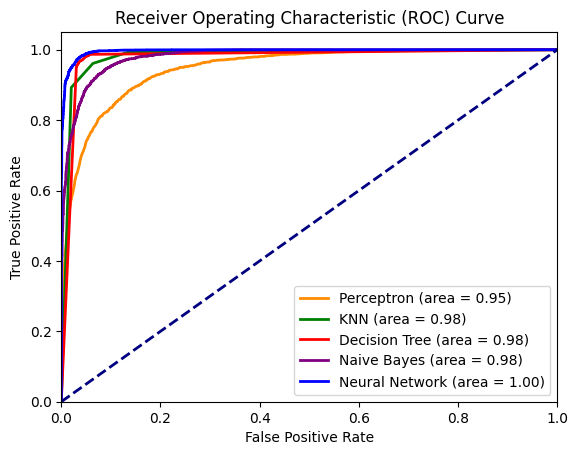

In [35]:
plt.plot(fpr_p, tpr_p, color='darkorange', lw=lw, label=f'Perceptron (area = {roc_auc_p:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=lw, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=lw, label=f'Decision Tree (area = {roc_auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, color='purple', lw=lw, label=f'Naive Bayes (area = {roc_auc_nb:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=lw,label=f'Neural Network (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Convert labels to categorical one-hot encoding
y_scaled = to_categorical(y)
y_train_scaled = to_categorical(y_train)
y_test_scaled = to_categorical(y_test)
y_val_scaled = to_categorical(y_val)

Epoch 1/50
242/242 [==============================] - 2s 4ms/step - loss: 0.2216 - accuracy: 0.9116 - val_loss: 0.1600 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 2/50
 48/242 [====>.........................] - ETA: 0s - loss: 0.1607 - accuracy: 0.9297

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 1s 3ms/step - loss: 0.1681 - accuracy: 0.9312 - val_loss: 0.1527 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 0.1463 - accuracy: 0.9396 - val_loss: 0.1365 - val_accuracy: 0.9458 - lr: 0.0010
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 0.1390 - accuracy: 0.9415 - val_loss: 0.1346 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 0.1306 - accuracy: 0.9475 - val_loss: 0.1207 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 0.1209 - accuracy: 0.9501 - val_loss: 0.1088 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 7/50
242/242 [==============================] - 1s 4ms/step - loss: 0.1148 - accuracy: 0.9510 - val_loss: 0.1118 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 8/50
242/242 [==============================] - 1s 4ms/step - loss: 0.1089 

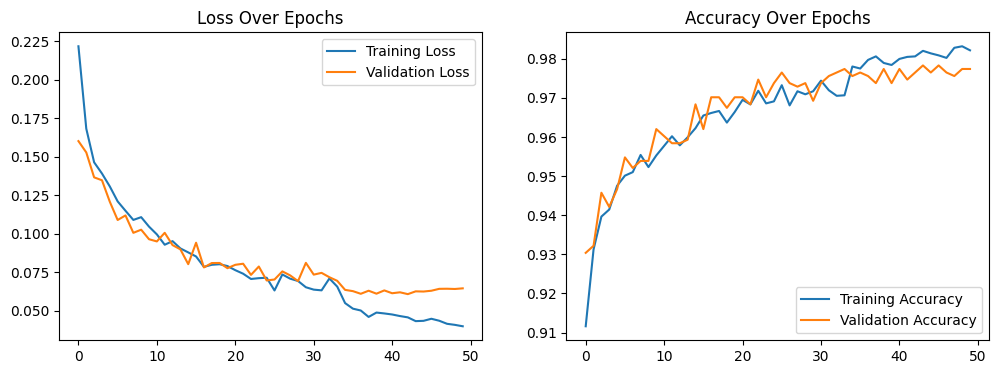

In [36]:
# Calculate class weights (useful if classes are imbalanced)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Simplifying the model
nn = models.Sequential()
nn.add(layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
nn.add(layers.Dropout(0.5))  # Adjust dropout rate
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dropout(0.5))  # Adjust dropout rate
nn.add(layers.Dense(y_train_scaled.shape[1], activation='softmax'))  # Assuming this is a classification problem

# Trying a different optimizer with a custom learning rate
opt = optimizers.Adam(learning_rate=0.001)

nn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# Train Model with callbacks
history = nn.fit(
    X_train_scaled, y_train_scaled, 
    validation_data=(X_val_scaled, y_val_scaled), 
    epochs=50,  # Adjusted epochs
    batch_size=32,  # Adjusted batch size
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate Model
test_loss, test_acc = nn.evaluate(X_test_scaled, y_test_scaled)
print('Test accuracy:', test_acc)

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()